In [0]:
# pyspark
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.functions import split, explode
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline

# for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# python standard libraries
from statistics import mean, variance
from math import log10, sqrt
from operator import add
from functools import reduce

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
comps_hiring_answers = spark.read.option("header", "false").csv("file:/Workspace/Users/vladklim@campus.technion.ac.il/Project/comps_hiring_answers.csv")
companies = spark.read.parquet('/linkedin/companies')

In [0]:
about_exists = udf(lambda x: "Exists" if x is not None and x != "" else "Doesn't exist")
relevant_columns = ["company_size", "followers", "founded", "industries", "organization_type", "hiring"]

In [0]:
tech_comps_all = companies.join(comps_hiring_answers, ("url"), "inner").fillna("Unknown", subset=relevant_columns).withColumn('about_exists', about_exists(col('about')))
relevant_columns.append("about_exists")

In [0]:
tech_comps_all.display()

url about affiliated company_id company_size country_code crunchbase_url employees employees_in_linkedin followers formatted_locations founded funding headquarters id image industries investors locations logo name organization_type similar slogan specialties sphere stock_info timestamp type updates website hiring about_exists https://www.linkedin.com/company/kern-web-design null List() 10515879 1 employee US null List(List(https://media.licdn.com/dms/image/C5103AQFr6kWsEJngXA/profile-displayphoto-shrink_100_100/0/1516438636996?e=1698278400&v=beta&t=ZxQ-TX960kemYj5w6xOxPfO7GIKmG2xs9OWNVMjaK3s, https://www.linkedin.com/in/joshuadavidkern?trk=org-employees, Web Designer and Developer, Josh Kern)) 1 2 List(433 E Orange St, Lancaster, Pennsylvania 17602, US) 2015 null Lancaster, Pennsylvania kern-web-design https://static.licdn.com/aero-v1/sc/h/5q92mjc5c51bjlwaj3rs9aa82 Technology, Information and Internet null List(433 E Orange St Lancaster, Pennsylvania 17602, US) https://media.licdn.com/dms/image/C4E0BAQHR6ThSqtyo8w/company-logo_200_200/0/1519895744123?e=2147483647&v=beta&t=SRkhTutbkaZ4LpNJR8Z-G7amuVyi2r1lpUvdVc8EaYs Kern Web Design Self-Owned List() null Web Design, Web Development, and Ecommerce Technology, Information and Internet null 2023-08-23 Self-Owned List() https://joshkern.co/ False Doesn't exist https://www.linkedin.com/company/5-and-2-studio null List() 11276722 2-10 employees US null List(List(https://media.licdn.com/dms/image/C5603AQHbAztjA3N_UA/profile-displayphoto-shrink_100_100/0/1516479346008?e=1698278400&v=beta&t=8PXayGMqiUzo9YEJsvgW2YYYzikq0IRbK7nxMlfmuLw, https://www.linkedin.com/in/bryanbanz?trk=org-employees, Software Engineer, Bryan Banz), List(https://media.licdn.com/dms/image/C5603AQFP3nSAtCAF4Q/profile-displayphoto-shrink_100_100/0/1517513143403?e=1698278400&v=beta&t=vHqSraKZzQyYhONdsFI0zwhzhaiIYUckp5Az5kOlea8, https://www.linkedin.com/in/dan-poblete?trk=org-employees, Founder Vitis Studio at Vitis Studio, LLC, Dan Poblete)) 2 12 List(10000 Marshall Drive, Lenexa, KS 66215, US, 14956 SW Scholls Ferry Rd, Beaverton, Oregon 97007, US) 2015 null Lenexa, KS 5-and-2-studio https://media.licdn.com/dms/image/C4E1BAQFm26rxsVdcFw/company-background_10000/0/1557938120165?e=1693465200&v=beta&t=HO2LdQxGFjIclLwd8GRew-rPV3QMvJGNAOfqFPViciE IT Services and IT Consulting null List(10000 Marshall Drive Lenexa, KS 66215, US, 14956 SW Scholls Ferry Rd Beaverton, Oregon 97007, US) https://media.licdn.com/dms/image/C4E0BAQFwgeucNJQJsA/company-logo_200_200/0/1519885378968?e=2147483647&v=beta&t=3fOqlSIHEXYjERPYu_RKlYbnGvps1lmWMrrDustsSDc 5 and 2 Studio Partnership List(List(https://www.linkedin.com/company/firemon?trk=similar-pages, Overland Park, Kansas, Software Development, FireMon), List(https://www.linkedin.com/company/ultimate-black-car-corp?trk=similar-pages, New York, New York, Truck Transportation, ULTIMATE BLACK CAR CORP), List(https://www.linkedin.com/company/endless-nameless?trk=similar-pages, null, Technology, Information and Internet, Endless Nameless), List(https://www.linkedin.com/company/thoits-insurance-service-inc.?trk=similar-pages, Mountain View, California, Insurance, THOITS INSURANCE SERVICE INC.), List(https://in.linkedin.com/company/mansdigital?trk=similar-pages, Coimbatore, Tamil Nadu, IT Services and IT Consulting, MANS Digital Solutions), List(https://www.linkedin.com/company/web-dev-u-s?trk=similar-pages, Scottsdale, AZ, Software Development, Web Dev U.S.), List(https://www.linkedin.com/company/lookout-mountain-tech-solutions?trk=similar-pages, null, Software Development, Lookout Mountain Tech Solutions), List(https://www.linkedin.com/company/enkolabs?trk=similar-pages, Issaquah, WA, IT Services and IT Consulting, Enkolabs), List(https://www.linkedin.com/company/adeptbisoftware?trk=similar-pages, Parker, CO, Software Development, Adept Software, LLC), List(https://www.linkedin.com/company/nuwrk?trk=similar-pages, Montreal, QC, Think Tanks, Nuwrk)) null null IT Services and IT Consulting null 202

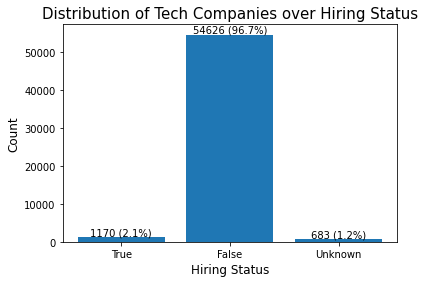

In [0]:
# Compute the count of each category
counts = sorted(tech_comps_all.groupBy("hiring").count().collect(),
                key=lambda x: ["True", "False", "Unknown"].index(x["hiring"]))

# Extract category labels and counts
categories = [row["hiring"] for row in counts]
counts = [row["count"] for row in counts]
total_count = tech_comps_all.count()

# Plot the distribution
plt.bar(categories, counts)
plt.xlabel("Hiring Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Tech Companies over Hiring Status", fontsize=15)
# Add counts text to each bar
for i, count in enumerate(counts):
    plt.text(i, count, f"{count} ({round(count / total_count, 3) * 100}%)", ha='center', va='bottom', fontsize=10)

plt.show()

In [0]:
def plot_bars_two_columns(df, col1_name, col2_name, col1_order, col2_order, label1, label2):

    counts = df.groupBy(col1_name, col2_name).count().collect()
    counts_matrix = [[0 for _ in range(len(col2_order))] for _ in range(len(col1_order))]

    for row in counts:
        count = row["count"]
        col1_idx = col1_order.index(row[col1_name])
        col2_idx = col2_order.index(row[col2_name])
        counts_matrix[col1_idx][col2_idx] = count

    normalized_counts = []
    for row in counts_matrix:
        total_count = sum(row)
        normalized_row = [count / total_count if total_count > 0 else 0 for count in row]
        normalized_counts.append(normalized_row)

    custom_colors = ['#167A08', '#D94C30', 'gray']
    fig, ax = plt.subplots(figsize=(20, 6))
    bar_width = 0.28
    bar_positions = range(len(col1_order))

    for i, cat in enumerate(col2_order):
        counts = [normalized_counts[j][i] for j in range(len(col1_order))]
        bars = ax.bar([pos + bar_width * i for pos in bar_positions], counts, bar_width, 
                    label=cat, color=custom_colors[i % len(custom_colors)])
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f"{count:.1%}", ha='center', va='bottom')

    ax.set_xlabel(label1, fontsize=15)
    ax.set_ylabel("Fraction", fontsize=15)
    ax.set_title(f"Distribution of {label2} for each {label1}", fontsize=20)
    ax.set_xticks([pos + bar_width * (len(col2_order) - 1) / 2 for pos in bar_positions])
    ax.set_xticklabels([f"{size}\n(count: {df.filter(col(col1_name) == size).count()})" for size in col1_order], 
                    rotation=45, fontsize=12)
    ax.legend(title=label2, loc="center right", fontsize=12)

    plt.show()

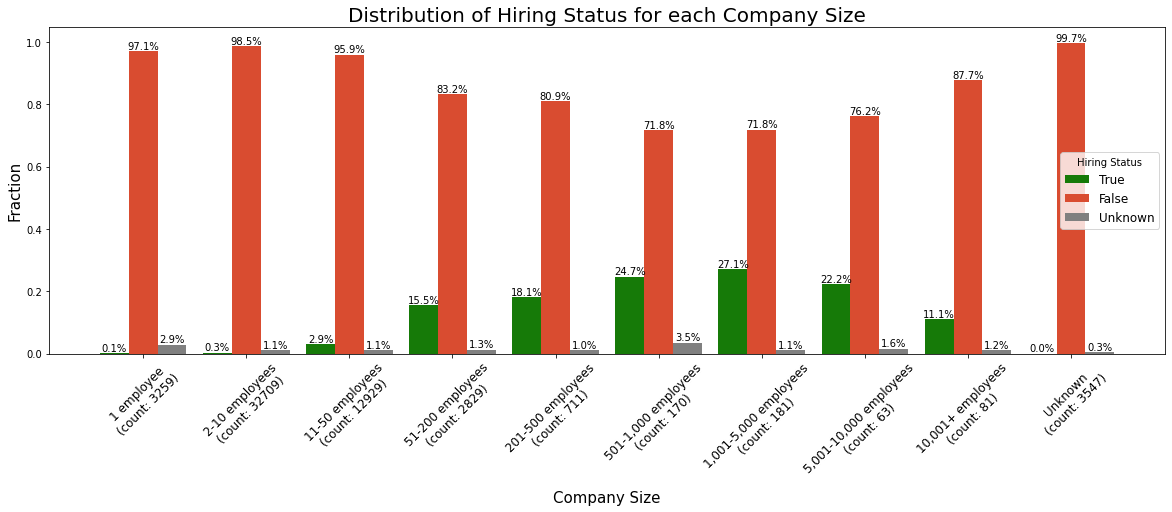

In [0]:
company_sizes = ["1 employee", "2-10 employees", "11-50 employees", "51-200 employees", "201-500 employees", 
                 "501-1,000 employees", "1,001-5,000 employees", "5,001-10,000 employees", "10,001+ employees", "Unknown"]
hiring_statuses = ["True", "False", "Unknown"]
label1, label2 = "Company Size", "Hiring Status"
plot_bars_two_columns(tech_comps_all, "company_size", "hiring", company_sizes, hiring_statuses, label1, label2)

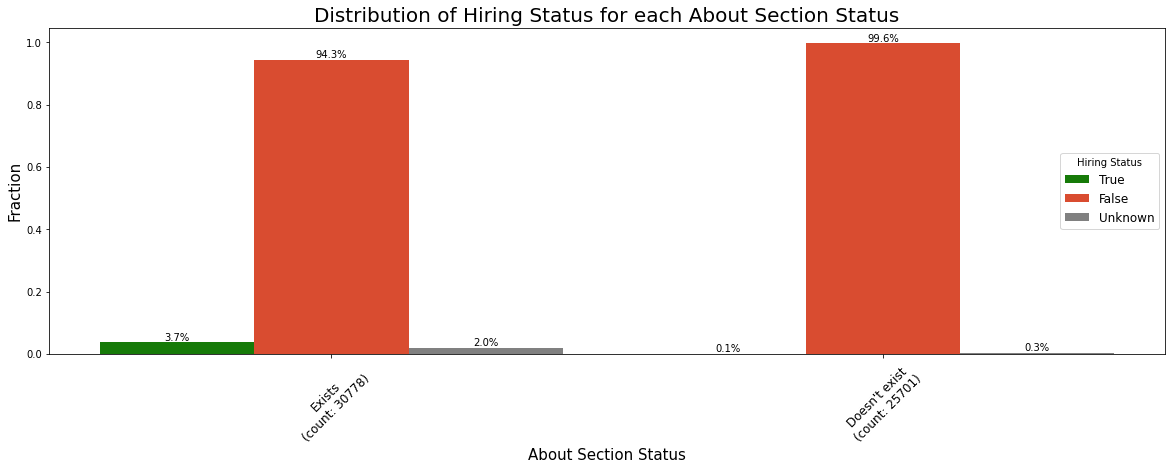

In [0]:
about_statuses = ["Exists", "Doesn't exist"]
hiring_statuses = ["True", "False", "Unknown"]
label1, label2 = "About Section Status", "Hiring Status"
plot_bars_two_columns(tech_comps_all, "about_exists", "hiring", about_statuses, hiring_statuses, label1, label2)

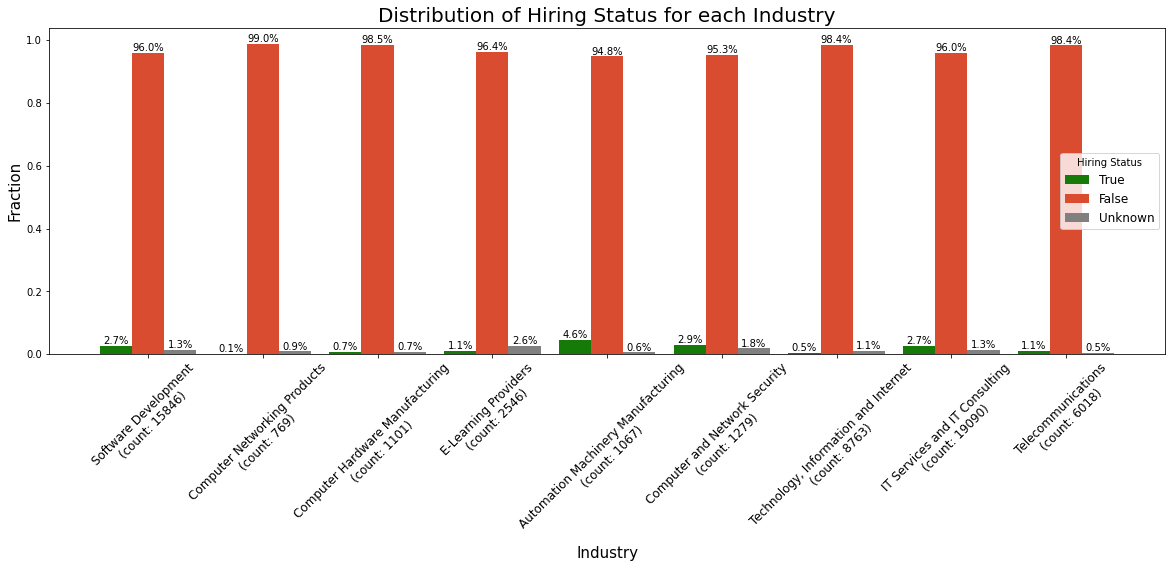

In [0]:
industries = ["Software Development", "Computer Networking Products", "Computer Hardware Manufacturing", "E-Learning Providers",
                  "Automation Machinery Manufacturing", "Computer and Network Security", "Technology, Information and Internet",
                  "IT Services and IT Consulting", "Telecommunications"]
hiring_statuses = ["True", "False", "Unknown"]
label1, label2 = "Industry", "Hiring Status"
plot_bars_two_columns(tech_comps_all, 
                      "industries", "hiring", industries, hiring_statuses, label1, label2)

For two categorical variables, you can perform the Chi-squared test of independence. This test is used to determine whether there is a significant association between two categorical variables. The null hypothesis of the Chi-squared test is that there is no association between the variables, meaning that they are independent.

To perform the Chi-squared test, you can create a contingency table (also known as a cross-tabulation or two-way table) that shows the frequency counts of the observations for each combination of categories from the two variables. You then calculate the expected counts under the assumption of independence and use these to compute the Chi-squared statistic. Finally, you compare the computed Chi-squared statistic to the critical value from the Chi-squared distribution to determine if the result is statistically significant.

In [0]:
def cramers_v(df, col1_name, col2_name):
        # Preparing the data
        indexer1 = StringIndexer(inputCol=col1_name, outputCol="category1_index")
        indexer2 = StringIndexer(inputCol=col2_name, outputCol="category2_index")

        assembler = VectorAssembler(inputCols=["category2_index"], outputCol="features")
        
        pipeline = Pipeline(stages=[indexer1, indexer2, assembler])
        assembled_df = pipeline.fit(df).transform(df)

        to_vector_udf = F.udf(lambda x: Vectors.dense(x), VectorUDT())
        assembled_df = assembled_df.withColumn("features", to_vector_udf("features"))

        # The Chi-squared test
        chi_sq_test = ChiSquareTest.test(assembled_df, "features", "category1_index")
        result_rows = chi_sq_test.collect()

        p_values = result_rows[0]["pValues"]
        degrees_of_freedom = result_rows[0]["degreesOfFreedom"]
        statistics = result_rows[0]["statistics"]

        chi_sq = chi_sq_test.select("statistics").collect()[0]["statistics"][0]  

        # Calculate Cramer's V
        n = assembled_df.count()
        r = assembled_df.select("category1_index").distinct().count()
        c = assembled_df.select("category2_index").distinct().count()
        v = sqrt(chi_sq / n / min((r-1), (c-1)))

        print("pValue:", p_values)
        print("degreesOfFreedom:", degrees_of_freedom)
        print("statistic:", statistics)
        print("Cramer's V:", v)
                
        return v


In [0]:
_ = cramers_v(tech_comps_all, "company_size", "hiring")

pValue: [0.0]
degreesOfFreedom: [18]
statistic: [5343.973475022051]
Cramer's V: 0.217507206048438


In your specific output, you have two sets of values, likely corresponding to two different tests (perhaps comparing two different sets of categories). The p-values of 0.0 suggest strong evidence against the null hypothesis of independence. The degrees of freedom indicate the number of categories minus one for each variable. The test statistics are large, indicating a significant deviation from expected frequencies.

In [0]:
cramers_v_matrix = []
for col1 in relevant_columns:
    row = []
    for col2 in relevant_columns:
        if col1 == col2:
            row.append(1.0)
        else:
            print(f"\n{col1} vs {col2}:")
            row.append(round(cramers_v(tech_comps_all, col1, col2), 3))
    cramers_v_matrix.append(row)


company_size vs followers:
pValue: [0.0]
degreesOfFreedom: [27252]
statistic: [142440.68686151222]
Cramer's V: 0.5293614065335527

company_size vs founded:
pValue: [0.0]
degreesOfFreedom: [1350]
statistic: [14736.558659174576]
Cramer's V: 0.17026809793239303

company_size vs industries:
pValue: [0.0]
degreesOfFreedom: [72]
statistic: [13830.70068461578]
Cramer's V: 0.17495791662398255

company_size vs organization_type:
pValue: [0.0]
degreesOfFreedom: [72]
statistic: [20413.639116609967]
Cramer's V: 0.21255519485179072

company_size vs hiring:
pValue: [0.0]
degreesOfFreedom: [18]
statistic: [5343.973475022051]
Cramer's V: 0.217507206048438

followers vs company_size:
pValue: [0.0]
degreesOfFreedom: [27252]
statistic: [142440.6868615054]
Cramer's V: 0.52936140653354

followers vs founded:
pValue: [0.0]
degreesOfFreedom: [454200]
statistic: [1110385.4061458942]
Cramer's V: 0.3620326537562199

followers vs industries:
pValue: [0.022468949379575553]
degreesOfFreedom: [24224]
statistic: [2

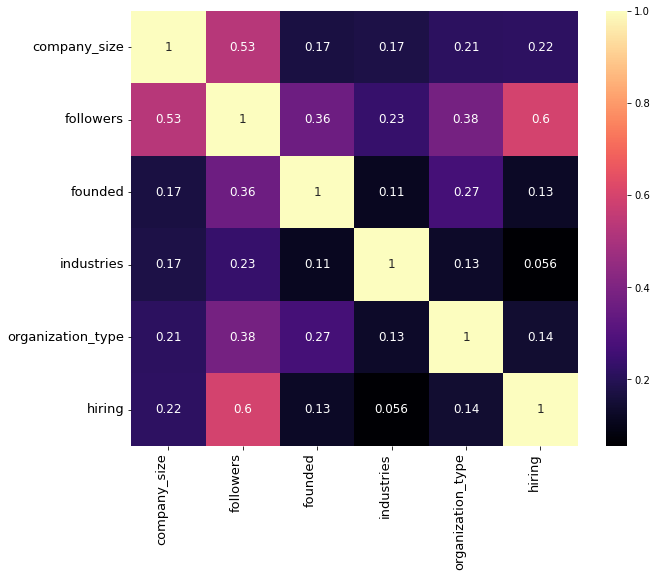

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pd.DataFrame(cramers_v_matrix, index=relevant_columns, columns=relevant_columns), 
            annot=True, annot_kws={'fontsize': 12}, cmap='magma')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=13)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=13)
plt.show()
